In [196]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt
from math import pi
from math import exp

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import graphviz
import pydot

from sklearn.externals.six import StringIO  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

In [201]:
dfTitanic = pd.read_csv('data_titanic_proyecto.csv')
dfTitanic.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [179]:
# weather=['Sunny','Sunny','Overcast','Rainy','Rainy','Rainy','Overcast','Sunny','Sunny',
# 'Rainy','Sunny','Overcast','Overcast','Rainy']
# temp=['Hot','Hot','Hot','Mild','Cool','Cool','Cool','Mild','Cool','Mild','Mild','Mild','Hot','Mild']

# play=['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']


# df = pd.DataFrame({
#     'weather' : weather,
#     'temp' : temp,
#      'play' : play
# })

# df["Y"] = df["play"].map( {'No': 0, 'Yes': 1}).astype(int)
# df["weather_encoded"] = df["weather"].map( {'Overcast': 0, 'Rainy': 1,'Sunny':2}).astype(int)
# df["temp_encoded"] = df["temp"].map( {'Cool': 0, 'Hot': 1,'Mild':2}).astype(int)

# x_test = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]])
# x_test.reshape(-1,1)

In [202]:
dfTitanic = dfTitanic.drop(["PassengerId", "Name", "Cabin"], axis = 1)
dfTitanic["passenger_sex"] = dfTitanic["passenger_sex"].map({'M': 0, 'F': 1}).astype(int)
dfTitanic["passenger_survived"] = dfTitanic["passenger_survived"].map({'N': 0, 'Y': 1}).astype(int)

dfTitanic.head()

,Age,SibSp,Parch,Ticket,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,A/5 21171,7.2500,S,Lower,0,0
1,38.0,1,0,PC 17599,71.2833,C,Upper,1,1
2,26.0,0,0,STON/O2. 3101282,7.9250,S,Lower,1,1
3,35.0,1,0,113803,53.1000,S,Upper,1,1
4,35.0,0,0,373450,8.0500,S,Lower,0,0


In [203]:
trainData, testData = train_test_split(dfTitanic, test_size = 0.2)
trainData, validationData = train_test_split(trainData, test_size = 0.2)

## Feature Engineering 

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived
0,-0.071103,-0.049662,0.055786,0.247208,0.539801,1.0


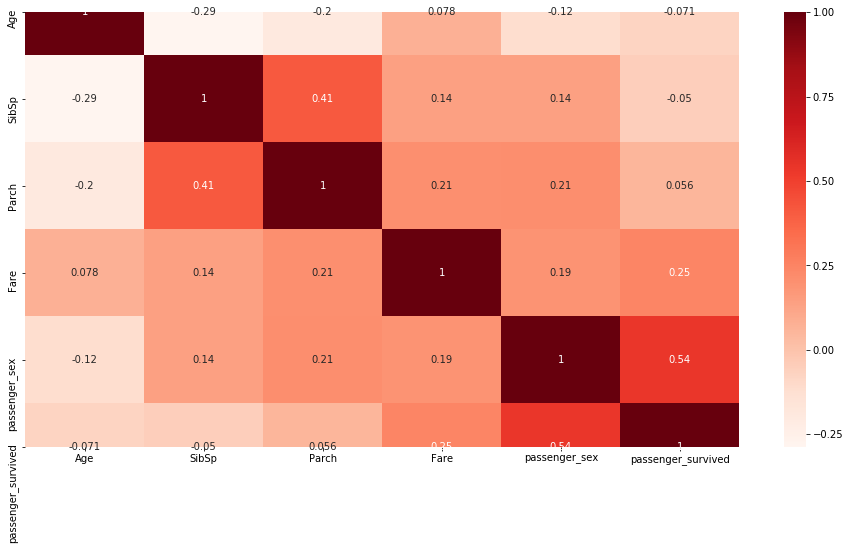

In [204]:
corr = trainData.corrwith(trainData["passenger_survived"])

plt.figure(figsize=(16, 8))
sns.heatmap(trainData.corr(), cmap="Reds", annot=True)

corr.to_frame().T

## Naive Bayes

In [220]:
def naiveBayes(df, yLabel, xPredict):
    n = df[yLabel].shape[0]
    nPredict = xPredict.shape[0]
    yUnique = df[yLabel].unique()

    means = df.groupby(yLabel).mean()
    stds = df.groupby(yLabel).std()

    classProbabilities = df.groupby(yLabel).apply(lambda x: len(x)) / n
    print(classProbabilities)

    probabilities = np.zeros((len(yUnique), nPredict))
    for class_ in yUnique:
        mean = means.iloc[class_].to_numpy()
        std = stds.iloc[class_].to_numpy()

        varsProbabilities = (1 / (sqrt(2 * np.pi) * std)) * np.exp(-((xPredict - mean) ** 2 / (2 * std ** 2)))
        probabilities[class_] = classProbabilities[class_] * np.product(varsProbabilities, axis = 1)
        # print(varsProbabilities)
        # probabilities[class_] = classProbabilities[class_] * np.product(varsProbabilities)

    print(probabilities)
    return np.argmax(probabilities.T, axis = 1)

In [219]:
# yPredict = naiveBayes(df, 'Y', x_test)
# print(df["passenger_sex"])
yPredict = naiveBayes(trainData[["passenger_sex", "passenger_survived"]], "passenger_survived", validationData["passenger_sex"])

yPredict

passenger_survived
0    0.625659
1    0.374341
dtype: float64
[[1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.47567705e-52 1.47567705e-52 1.47567705e-52 1.47567705e-52
  1.4756

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Decision Tree

In [164]:
tree = DecisionTreeClassifier()
tree = tree.fit(df[["weather_encoded", "temp_encoded"]], df['Y'])
yTree = tree.predict(x_test)

yTree

KeyError: "None of [Index(['weather_encoded', 'temp_encoded'], dtype='object')] are in the [columns]"

In [165]:
dot_data = export_graphviz(tree, out_file=None,
                                        feature_names=["weather","temp"],
                                        class_names=["not_play","play"],
                                        filled=True, rounded=True,
                                        special_characters=True)
graph = graphviz.Source(dot_data)
graph

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## SVM

In [166]:
svm = SVC(kernel = 'linear')

svm = svm.fit(df[["weather_encoded", "temp_encoded"]], df['Y'])
ySvm = svm.predict(x_test)

ySvm

KeyError: "None of [Index(['weather_encoded', 'temp_encoded'], dtype='object')] are in the [columns]"

In [167]:
def logisticRegression(x, y, epochs, lr, batchSize, regularization, beta, modelName, printRate):
    tf.reset_default_graph()
    
    n = x.shape[0]

    totalIterations = int(n / batchSize)
    x = np.hstack((x, np.ones((n, 1))))
    y = y.reshape(-1, 1)

    vars_ = x.shape[1]

    with tf.name_scope("intup"):
        #x = tf.concat([x, tf.ones_like(x)], axis = 1)
        xTrain = tf.placeholder(tf.float32, [batchSize, vars_], "x")
        yTrain = tf.placeholder(tf.float32, [batchSize, 1], "y")
    with tf.name_scope("params"):
        #params = tf.Variable(name="params", initial_value = tf.zeros((2 , 1), tf.float64))
        params = tf.Variable(name = "params", initial_value = tf.zeros(([vars_, 1]), dtype = tf.float32))
        #biases = tf.Variable(tf.zeros([num_labels]))
    with tf.name_scope("logits"):
        logits = tf.matmul(xTrain, params)
    with tf.name_scope("loss"):
        #error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = yTrain))
    with tf.name_scope("gradient"):
        gradients = tf.gradients(loss, params)
    with tf.name_scope("model"):
        fit = tf.scalar_mul(-lr, gradients[0])
        model = tf.assign(params, tf.add(params, fit))


    with tf.Session() as session:
        # summary = tf.summary.scalar(name = "error_epochs", tensor = loss)
        writer = tf.summary.FileWriter("./" + modelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs), session.graph)
        session.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for i in range(totalIterations):
                start = i * batchSize
                end = start + batchSize
                
                x_ = np.array(x[start:end])
                y_ = np.array(y[start:end])
                # print("yyyyyyyy")
                # print(y_)
                # print(yTrain)
                # print("xxxxxxxx")
                # print(x_)
                # print(xTrain)
                feedDict = {xTrain: x_, yTrain: y_}
                session.run(model, feed_dict = feedDict)

                if ((epoch + 1) % printRate) == 0:
                    print("error: " + str(session.run(loss, feed_dict = feedDict)))
      
            #writer.add_summary(session.run(summary), epoch)

        params = session.run(params)

        writer.close()
    session.close()

    return params

In [168]:
coeficients = logisticRegression(x = df[["weather_encoded", "temp_encoded"]].to_numpy(), y = df["Y"].to_numpy(), epochs = 3000, lr = 0.8, batchSize = 8, regularization = 0, beta = 0, modelName = "titanic", printRate = 100)
coeficients

KeyError: "None of [Index(['weather_encoded', 'temp_encoded'], dtype='object')] are in the [columns]"

In [169]:
def lr_predict_class(x, coeficients):
    x = np.hstack((x, np.ones((x.shape[0],1))))
    tf.reset_default_graph()
    x_tf = tf.placeholder(tf.float32, [x.shape[0], None], "xp")
    with tf.Session() as session:
        print(session.run(tf.nn.sigmoid(tf.matmul(x_tf, coeficients)), feed_dict={x_tf: x}))
        prediction = session.run(tf.cast(tf.nn.sigmoid(tf.matmul(x_tf,coeficients)) > 0.5, tf.int32),feed_dict={x_tf: x})
        
        session.close()
    return prediction

In [170]:
lr_predict_class(x_test, coeficients)

[[9.9974960e-01]
 [9.9996740e-01]
 [9.9999577e-01]
 [4.9525085e-01]
 [8.8284326e-01]
 [9.8301458e-01]
 [2.4104118e-04]
 [1.8482804e-03]
 [1.4021679e-02]]


array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0]], dtype=int32)